In [1]:
import json
import os
import sys

from datetime import datetime
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tabula
import zipfile

from matplotlib.dates import DateFormatter


pd.set_option("display.max_columns", None)
sys.path.append("../..")

from src.utils.download import download_file_from_url
from src.utils.plot import plot_bar, plot_hist, plot_pie
from src.utils.states import abbrev_to_state

INPUT_DATA_DIR = "./input_data"
OUTPUT_IMAGE_DIR = "./images/ct_claims"
OUTPUT_DATA_DIR = "./output_data/ct_claims"  # Set to None if you don't want to save non-required data for external use

In [2]:
os.makedirs(INPUT_DATA_DIR, exist_ok=True)
if OUTPUT_IMAGE_DIR:
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
if OUTPUT_DATA_DIR:
    os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

# 2022 Report (2021 Plan Year)

In [3]:
url = "https://portal.ct.gov/-/media/CID/1_Reports/2022-ConsumerReportCard.pdf"
pages = [7, 8] + list(range(29, 49 + 1)) + [52, 55, 56, 57, 58, 59]
dfs = tabula.read_pdf(url, stream=True, pages=pages)

## Enrollment Plots

In [4]:
enrollment_int_cols = [
    "fi_ind",
    "fi_sg",
    "fi_lg",
    "si_ind",
    "si_sg",
    "si_lg",
    "tot_ind",
    "tot_sg",
    "tot_lg",
]
enrollment_cols = ["insurer"] + enrollment_int_cols
hmo_enrollment_table = dfs[1].iloc[2:]
hmo_enrollment_table.columns = enrollment_cols
indemnity_enrollment_table = dfs[2].iloc[2:]
indemnity_enrollment_table.columns = enrollment_cols

In [5]:
def clean_and_cast_to_int(df: pd.DataFrame, int_cols: list[str]) -> pd.DataFrame:
    df = df.copy()
    for col in int_cols:
        df[col] = df[col].apply(lambda x: int(x.replace(",", "").replace("***", "")))
    return df

In [6]:
hmo_enrollment_table = clean_and_cast_to_int(hmo_enrollment_table, enrollment_int_cols)
indemnity_enrollment_table = clean_and_cast_to_int(
    indemnity_enrollment_table, enrollment_int_cols
)

In [7]:
hmo_enrollment_table

,insurer,fi_ind,fi_sg,fi_lg,si_ind,si_sg,si_lg,tot_ind,tot_sg,tot_lg
2,Aetna Health,0,1,60,0,0,141,0,1,201
3,Anthem,11732,337,1249,0,115,229675,11732,452,230924
4,ConnectiCare,2675,347,13290,0,0,0,2675,347,13290
5,Harvard,0,2947,1801,0,0,0,0,2947,1801
6,Oxford,0,2455,3052,0,0,0,0,2455,3052
7,Totals,14407,6087,19452,0,115,229816,14407,6202,249268


In [8]:
indemnity_enrollment_table

,insurer,fi_ind,fi_sg,fi_lg,si_ind,si_sg,si_lg,tot_ind,tot_sg,tot_lg
2,Aetna Life,0,1592,53395,0,14193,232833,0,15785,286228
3,Anthem,19699,24737,47834,0,0,742195,19699,24737,790029
4,Cigna H & L,0,6161,48389,0,1700,275907,0,7861,324296
5,ConnectiCare Benefits,72761,5400,0,0,0,0,72761,5400,0
6,ConnectiCare,2604,17177,28573,0,7868,3029,2604,25045,31602
7,HPHC,0,3344,7224,0,0,0,0,3344,7224
8,Oxford Health,0,41046,10274,0,0,0,0,41046,10274
9,United,0,2108,51983,0,0,0,0,2108,51983
10,Totals,95064,101565,247672,0,23761,1253964,95064,125326,1501636


In [9]:
def get_totals_dict(df: pd.DataFrame, group_label: str) -> dict:
    total_enrollment = df.iloc[-1][["tot_ind", "tot_sg", "tot_lg"]].sum(axis=0)

    total_si = df.iloc[-1][["si_sg", "si_lg"]].sum(axis=0)
    total_fi = df.iloc[-1][["fi_ind", "fi_sg", "fi_lg"]].sum(axis=0)
    total_ind = df.iloc[-1]["tot_ind"]
    total_sg = df.iloc[-1]["tot_sg"]
    total_lg = df.iloc[-1]["tot_lg"]
    insurers = {}
    for row in df.itertuples():
        if row.insurer != "Totals":
            insurers[row.insurer] = row.tot_ind + row.tot_sg + row.tot_lg

    assert total_si + total_fi == total_enrollment
    assert total_ind + total_sg + total_lg == total_enrollment
    assert sum(insurers.values()) == total_enrollment

    return {
        group_label: {
            "total": total_enrollment,
            "si": total_si,
            "fi": total_fi,
            "ind": total_ind,
            "sg": total_sg,
            "lg": total_lg,
            "insurers": insurers,
        }
    }

In [10]:
enrollments = {}
enrollments.update(get_totals_dict(hmo_enrollment_table, "hmo"))
enrollments.update(get_totals_dict(indemnity_enrollment_table, "indemnity"))

In [11]:
enrollments

{'hmo': {'total': 269877,
  'si': 229931,
  'fi': 39946,
  'ind': 14407,
  'sg': 6202,
  'lg': 249268,
  'insurers': {'Aetna Health': 202,
   'Anthem': 243108,
   'ConnectiCare': 16312,
   'Harvard': 4748,
   'Oxford': 5507}},
 'indemnity': {'total': 1722026,
  'si': 1277725,
  'fi': 444301,
  'ind': 95064,
  'sg': 125326,
  'lg': 1501636,
  'insurers': {'Aetna Life': 302013,
   'Anthem': 834465,
   'Cigna H & L': 332157,
   'ConnectiCare Benefits': 78161,
   'ConnectiCare': 59251,
   'HPHC': 10568,
   'Oxford Health': 51320,
   'United': 54091}}}

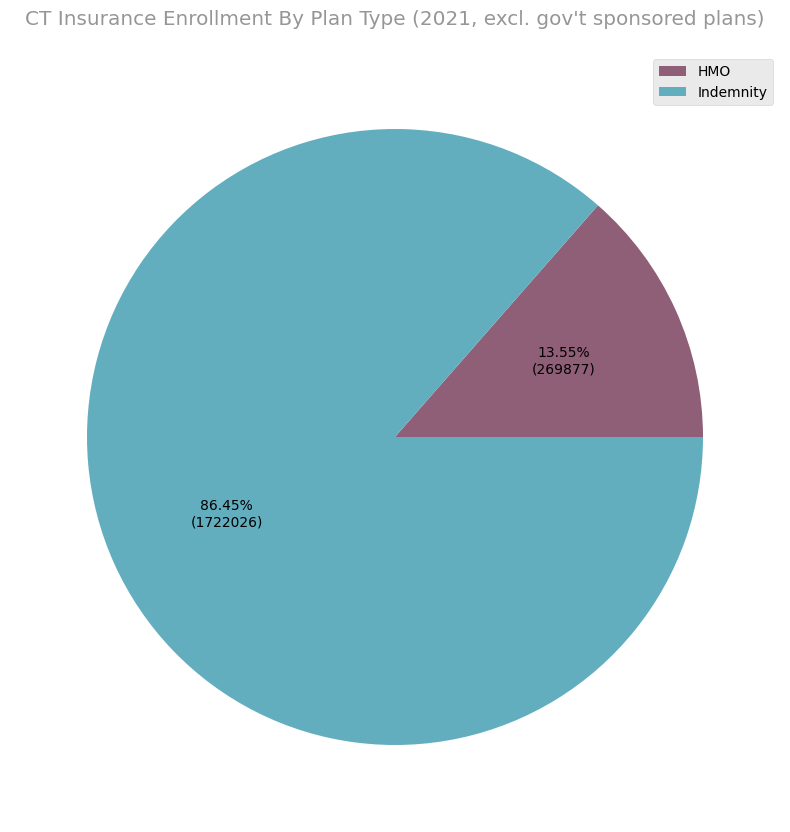

In [12]:
# Enrollment by Plan Type
title = "CT Insurance Enrollment By Plan Type (2021, excl. gov't sponsored plans)"
slice_names = ["HMO", "Indemnity"]
slice_vals = [enrollments["hmo"]["total"], enrollments["indemnity"]["total"]]
plot_pie(
    slice_names=slice_names,
    slice_vals=slice_vals,
    title=title,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "enrollment_by_plan_type.png"),
)

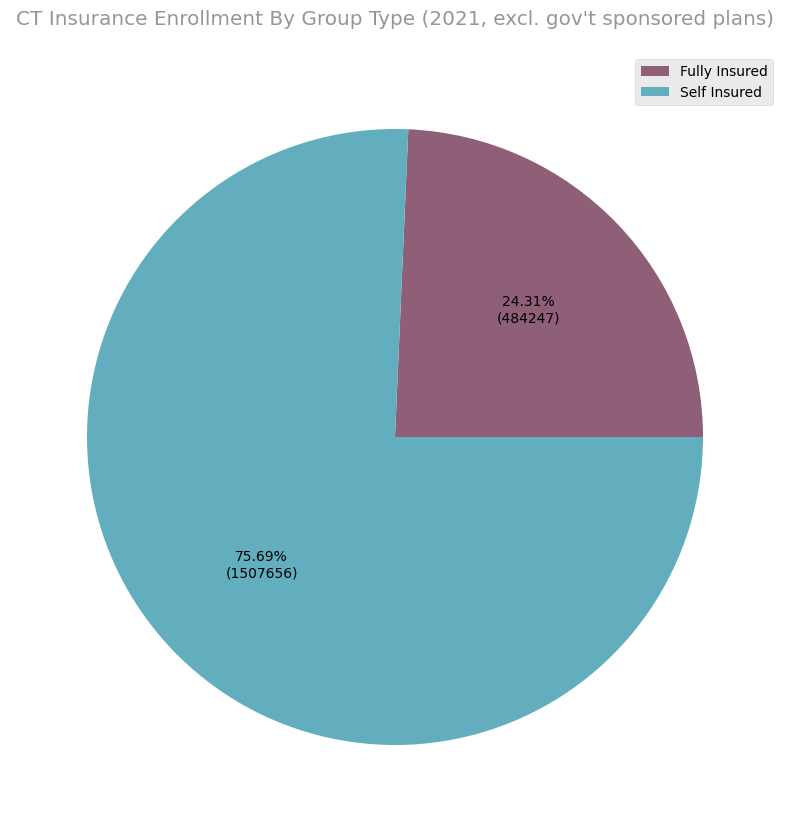

In [13]:
# Enrollment by Payer Type
title = "CT Insurance Enrollment By Group Type (2021, excl. gov't sponsored plans)"
slice_names = ["Fully Insured", "Self Insured"]
slice_vals = [
    enrollments["hmo"]["fi"] + enrollments["indemnity"]["fi"],
    enrollments["hmo"]["si"] + enrollments["indemnity"]["si"],
]
plot_pie(
    slice_names=slice_names,
    slice_vals=slice_vals,
    title=title,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "enrollment_by_payer_type.png"),
)

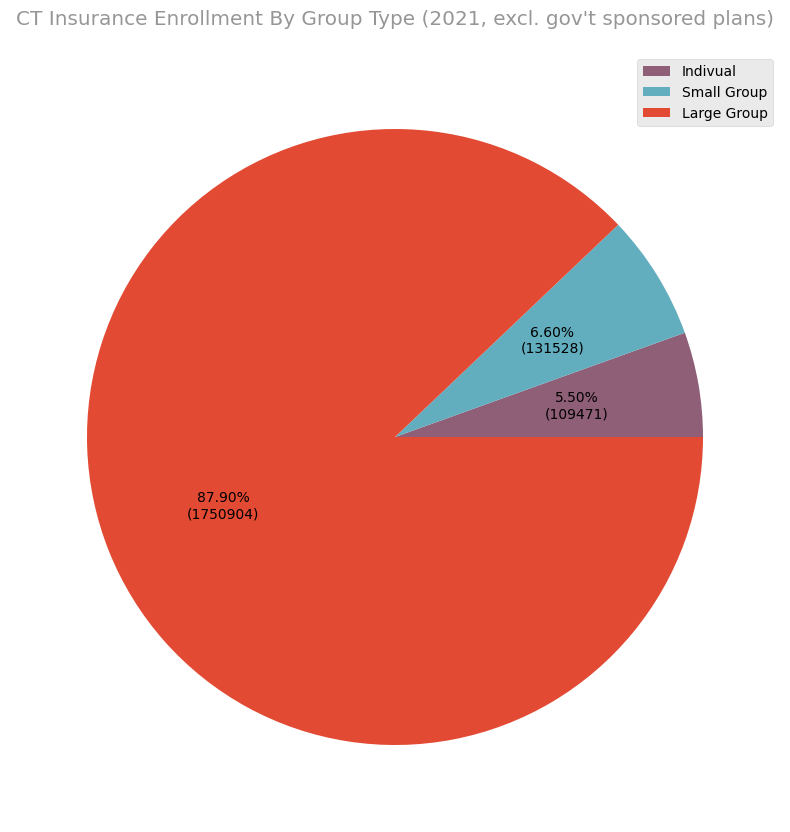

In [14]:
# Enrollment by Group Type
title = "CT Insurance Enrollment By Group Type (2021, excl. gov't sponsored plans)"
slice_names = ["Indivual", "Small Group", "Large Group"]
slice_vals = [
    enrollments["hmo"]["ind"] + enrollments["indemnity"]["ind"],
    enrollments["hmo"]["sg"] + enrollments["indemnity"]["sg"],
    enrollments["hmo"]["lg"] + enrollments["indemnity"]["lg"],
]
plot_pie(
    slice_names=slice_names,
    slice_vals=slice_vals,
    title=title,
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "enrollment_by_group_type.png"),
)

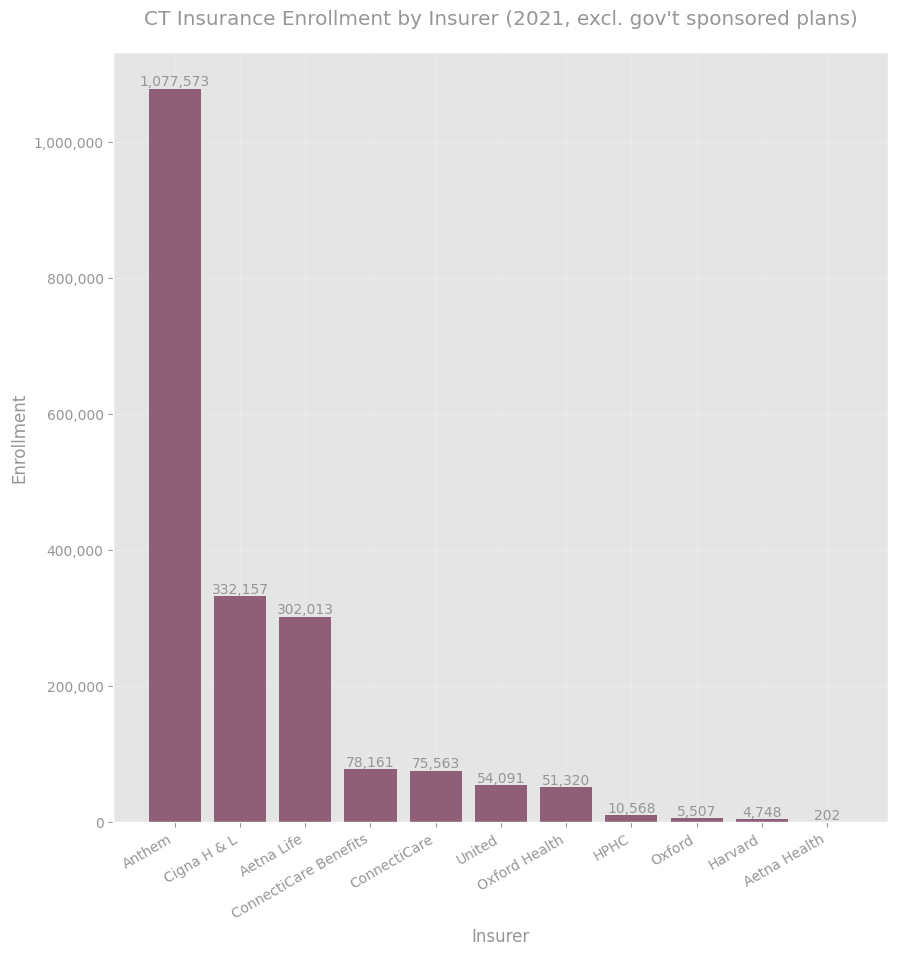

In [15]:
# Insurer breakdown by enrollment

# Get enrollment counts irrespective of plan type
x = enrollments["hmo"]["insurers"]
y = enrollments["indemnity"]["insurers"]
insurers = {k: x.get(k, 0) + y.get(k, 0) for k in set(x) | set(y)}
insurers = dict(sorted(insurers.items(), key=lambda item: item[1], reverse=True))


title = "CT Insurance Enrollment by Insurer (2021, excl. gov't sponsored plans)"
val_axis_label = "Enrollment"
cat_axis_label = "Insurer"

bar_names, bar_vals = list(insurers.keys()), insurers.values()
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "enrollment_by_insurer.png"),
    bar_label=True,
    figsize=(10, 10),
)

## Claims Plots

In [16]:
# Overall Denial Rate in Data

# Denial Rate for HMOS

# Denial Rate for Indemnity

# Denial Rates By Insurer

# Appeal Rates, Appeal Success Rates

# Estimate cost based on per member per month #s and enrollment?

In [18]:
# Indemnity Claim Denial Data
# Code to make one vomit. This PDF does not want to be parsed.
ind_1 = dfs[-3].drop(columns=[f"Unnamed: {i}" for i in range(0, 4)])
ind_2 = (
    dfs[-2]
    .drop(columns=[f"Unnamed: {i}" for i in range(0, 4)])
    .rename(columns={"Claim Denial Data (continued)": "Claim Denial Data"})
)
df = pd.concat([ind_1, ind_2]).reset_index(drop=True)

In [19]:
new_col_map = {
    "index": "insurer",
    0: "claims_received",
    3: "denials_not_covered",
    4: "denials_nmn",
    5: "denials_non_eligible_enrollee",
    6: "denials_incomplete",
    7: "denials_duplicate",
    8: "denials_other",
    20: "internal_appeals_not_covered",
    21: "internal_appeals_nmn",
    22: "internal_appeals_non_eligible_enrollee",
    23: "internal_appeals_incomplete",
    24: "internal_appeals_duplicate",
    25: "internal_appeals_other",
    36: "internal_appeals_rev_not_covered",
    37: "internal_appeals_rev_nmn",
    38: "internal_appeals_rev_non_eligible_enrollee",
    39: "internal_appeals_rev_incomplete",
    40: "internal_appeals_rev_duplicate",
    41: "internal_appeals_rev_other",
}
retain_cols = new_col_map.values()
df = df.T.reset_index().rename(columns=new_col_map)[retain_cols].iloc[1:]
df = clean_and_cast_to_int(df, int_cols=[x for x in retain_cols if x != "insurer"])

In [20]:
prefixes = ["denials", "internal_appeals", "internal_appeals_rev"]
for pfx in prefixes:
    df[pfx] = (
        df[f"{pfx}_not_covered"]
        + df[f"{pfx}_nmn"]
        + df[f"{pfx}_non_eligible_enrollee"]
        + df[f"{pfx}_incomplete"]
        + df[f"{pfx}_duplicate"]
        + df[f"{pfx}_other"]
    )
df["denial_rate"] = df["denials"] / df["claims_received"]
df["internal_appeal_rate"] = df["internal_appeals"] / df["denials"]
df["internal_appeal_overturn_rate"] = (
    df["internal_appeals_rev"] / df["internal_appeals"]
)

In [21]:
def get_denials_dict(df: pd.DataFrame, group_label: str) -> dict:
    claims_received = df["claims_received"].sum()
    claims_denied = df["denials"].sum()
    claims_internally_appealed = df["internal_appeals"].sum()
    claims_internally_overturned = df["internal_appeals_rev"].sum()
    overall_denial_rate = claims_denied / claims_received
    overall_internal_appeal_rate = claims_internally_appealed / claims_denied
    overall_internal_appeal_overturn_rate = (
        claims_internally_overturned / claims_internally_appealed
    )

    insurers = {}
    for row in df.itertuples():
        insurers[row.insurer] = {
            "claims_received": row.claims_received,
            "claims_denied": row.denials,
            "claims_appealed": row.internal_appeals,
            "claims_overturned": row.internal_appeals_rev,
            "denial_rate": row.denial_rate,
            "internal_appeal_rate": row.internal_appeal_rate,
            "internal_appeal_success_rate": row.internal_appeal_overturn_rate,
        }

    return {
        group_label: {
            "claims_received": claims_received,
            "claims_denied": claims_denied,
            "claims_appealed": claims_internally_appealed,
            "claims_overturned": claims_internally_overturned,
            "denial_rate": overall_denial_rate,
            "internal_appeal_rate": overall_internal_appeal_rate,
            "internal_appeal_success_rate": overall_internal_appeal_overturn_rate,
            "insurers": insurers,
        }
    }

In [22]:
# TODO: Republish this data in transparency data
indemnity_denials_dict = get_denials_dict(df, "indemnity")

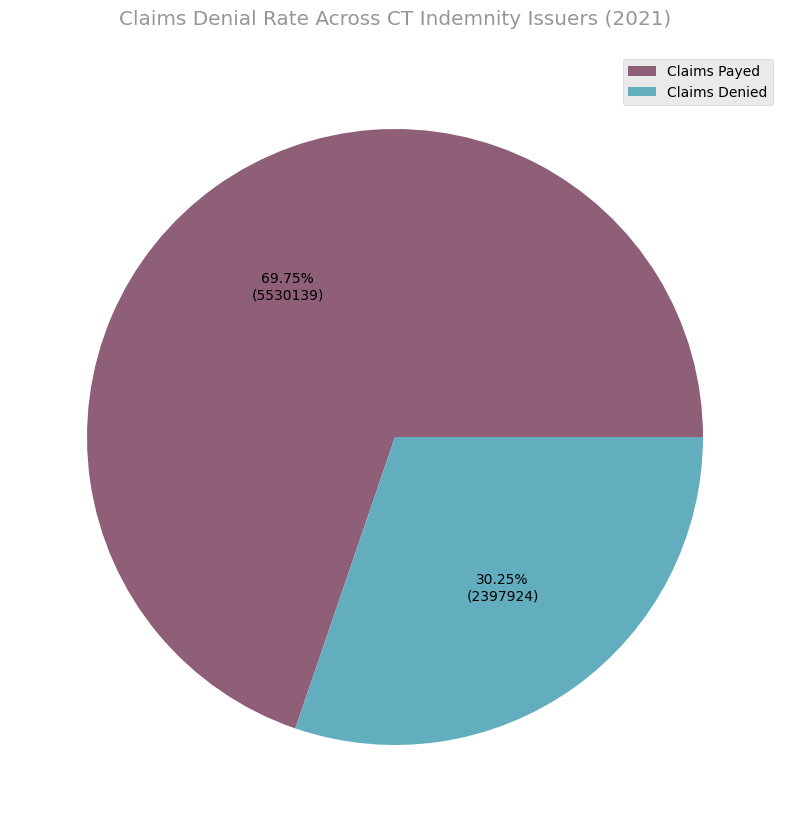

In [23]:
# Indemnity Plans Overall Denial Rate
plot_pie(
    slice_names=["Claims Payed", "Claims Denied"],
    slice_vals=[
        indemnity_denials_dict["indemnity"]["claims_received"]
        - indemnity_denials_dict["indemnity"]["claims_denied"],
        indemnity_denials_dict["indemnity"]["claims_denied"],
    ],
    title="Claims Denial Rate Across CT Indemnity Issuers (2021)",
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "indemnity_overall_denial_pie.png"),
)

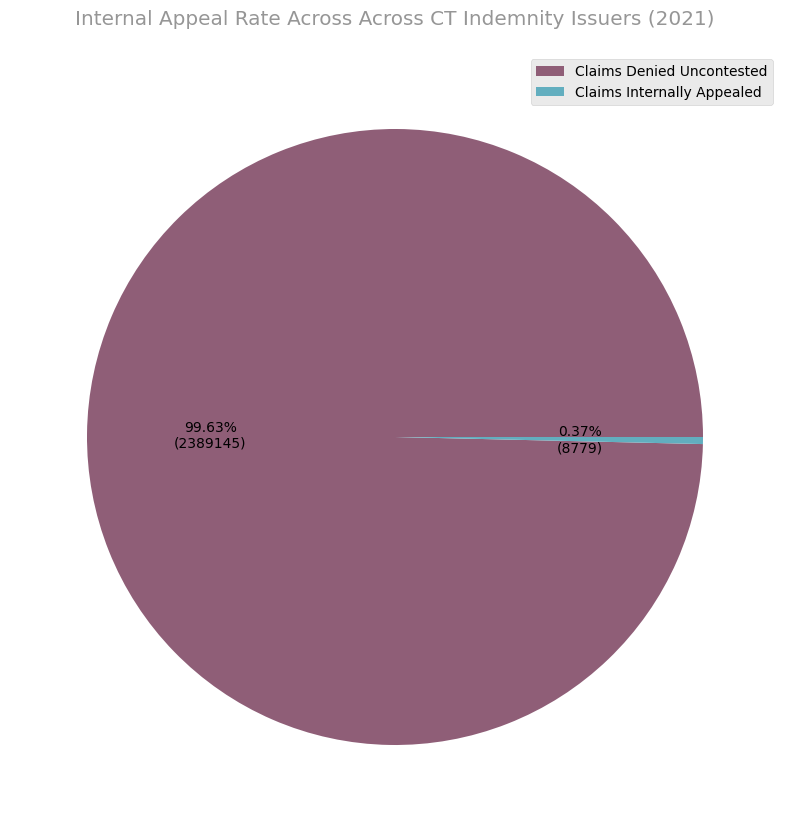

In [24]:
# Indemnity Plans Overall Appeal Rate
plot_pie(
    slice_names=["Claims Denied Uncontested", "Claims Internally Appealed"],
    slice_vals=[
        indemnity_denials_dict["indemnity"]["claims_denied"]
        - indemnity_denials_dict["indemnity"]["claims_appealed"],
        indemnity_denials_dict["indemnity"]["claims_appealed"],
    ],
    title="Internal Appeal Rate Across Across CT Indemnity Issuers (2021)",
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "indemnity_internal_appeal_rates_all_insurers.png"
    ),
    show=True,
)

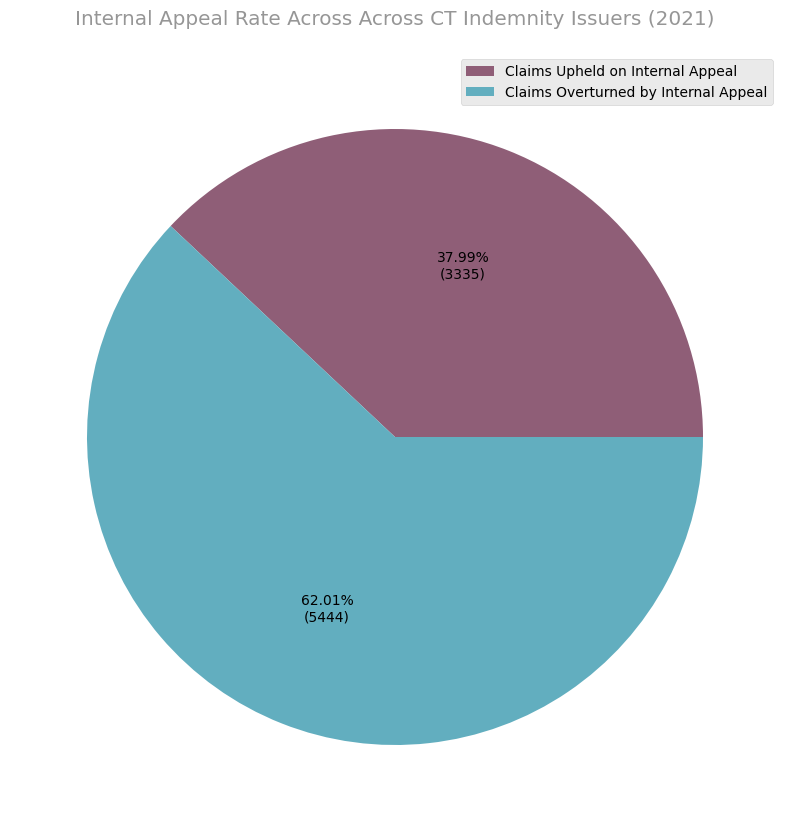

In [25]:
plot_pie(
    slice_names=[
        "Claims Upheld on Internal Appeal",
        "Claims Overturned by Internal Appeal",
    ],
    slice_vals=[
        indemnity_denials_dict["indemnity"]["claims_appealed"]
        - indemnity_denials_dict["indemnity"]["claims_overturned"],
        indemnity_denials_dict["indemnity"]["claims_overturned"],
    ],
    title="Internal Appeal Rate Across Across CT Indemnity Issuers (2021)",
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "indemnity_internal_appeal_success_rates_all_insurers.png"
    ),
    show=True,
)